In [268]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import STL10
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np

# Dataset

In [253]:
batch_size = 200
# Data augmentation and normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load STL-10 dataset
train_dataset = STL10(root='./data', split='train', transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = STL10(root='./data', split='test', transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


# Model

In [269]:
# Hyperparameters
input_dim = 3 * 96 * 96  # STL-10 image size is 96x96x3
num_classes = 10
epochs = 100

In [270]:
# Define the linear classifier model
class LinearClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        out = self.fc(x)
        #return nn.functional.softmax(out, dim=1)
        return out

In [271]:
# Initialize model, loss function, optimizer, and learning rate scheduler
model = LinearClassifier(input_dim, num_classes)

# Criterion / Loss Function

In [272]:
criterion = nn.CrossEntropyLoss()

# Optimizer

In [273]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas= (0.9, 0.999), weight_decay=0.1)
#optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.7)  # Set the momentum value

# Learning Rate Scheduler

In [274]:
#scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Training Loop

In [276]:
# Training loop
best_acc = float('-inf')
best_model_state = None

all_loss = []
all_accuracy = []
correct = 0
total = 0
epochs = 200

for epoch in range(epochs):
    model.train()

    for batch_data, batch_labels in train_loader:
        batch_data = batch_data.view(-1, input_dim)
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        all_loss.append(loss.item())

        _, predicted = torch.max(outputs.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()
        accuracy = correct / total
        all_accuracy.append(accuracy)
    
    print(f"Epoch {epoch + 1}, Accuracy: {accuracy}, Loss: {loss.item()}")

    #scheduler.step()
    '''
    # Update best model if this epoch had the lowest loss so far
    if loss.item() < best_loss:
        best_loss = loss.item()
        print(f'best loss {best_loss}')
        best_model_state = model.state_dict()
    '''

    
    # Update best model if this epoch had the higest accuracy so far
    if accuracy > best_acc:
        best_acc = accuracy
        print(f'best accuracy {best_acc}')
        best_model_state = model.state_dict()
    

# Load the best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded the model with the highest accuracy.")

Epoch 1, Accuracy: 0.3866, Loss: 1.746962070465088
best accuracy 0.3866
Epoch 2, Accuracy: 0.4054, Loss: 1.574476957321167
best accuracy 0.4054
Epoch 3, Accuracy: 0.4225333333333333, Loss: 1.723292350769043
best accuracy 0.4225333333333333
Epoch 4, Accuracy: 0.43455, Loss: 1.5713837146759033
best accuracy 0.43455
Epoch 5, Accuracy: 0.44624, Loss: 1.4032249450683594
best accuracy 0.44624
Epoch 6, Accuracy: 0.4563333333333333, Loss: 1.3718724250793457
best accuracy 0.4563333333333333
Epoch 7, Accuracy: 0.46562857142857145, Loss: 1.3611187934875488
best accuracy 0.46562857142857145
Epoch 8, Accuracy: 0.47505, Loss: 1.4018281698226929
best accuracy 0.47505
Epoch 9, Accuracy: 0.48284444444444446, Loss: 1.4714303016662598
best accuracy 0.48284444444444446
Epoch 10, Accuracy: 0.49108, Loss: 1.3128308057785034
best accuracy 0.49108
Epoch 11, Accuracy: 0.49914545454545456, Loss: 1.4397120475769043
best accuracy 0.49914545454545456
Epoch 12, Accuracy: 0.5063166666666666, Loss: 1.3870704174041748

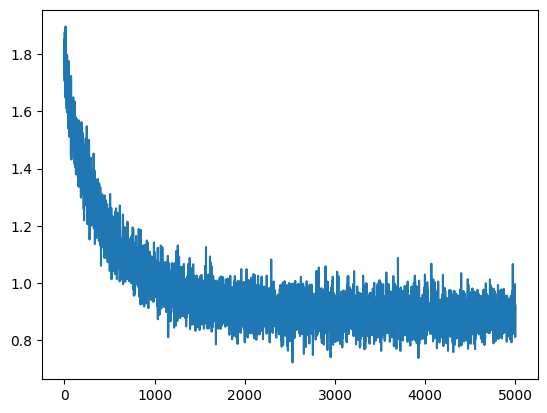

In [289]:
plt.plot(all_loss)

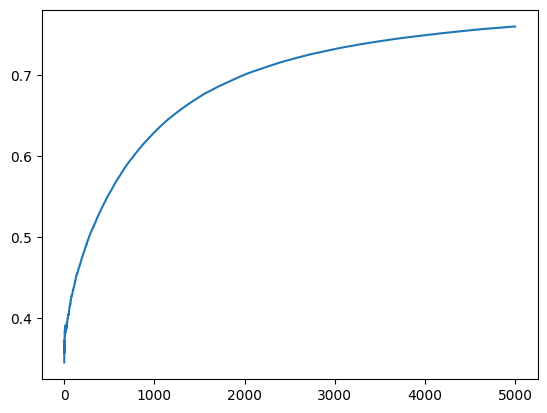

In [290]:
plt.plot(all_accuracy)

# Evaluation Loop

In [279]:
PATH = './stl10_model.pth'
torch.save(model.state_dict(), PATH)

In [280]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

In [286]:
num_pixels = 96*96*3
num_classes = 10

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

model = LinearClassifier(num_pixels, num_classes)
model.load_state_dict(torch.load(PATH))
model.eval()

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
val_acc = []

with torch.no_grad():
    for batch_data, batch_labels in test_loader:
        batch_data = batch_data.view(-1, num_pixels)  # Corrected input_dim to num_pixels

        outputs = model(batch_data)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(batch_labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Print accuracy for each class
for classname, correct_count in correct_pred.items():
    total_count = total_pred[classname]
    accuracy = correct_count / total_count if total_count > 0 else 0.0
    print(f"Accuracy for {classname}: {100 * accuracy:.2f}%")


Accuracy for plane: 52.75%
Accuracy for car: 21.25%
Accuracy for bird: 54.50%
Accuracy for cat: 19.88%
Accuracy for deer: 31.00%
Accuracy for dog: 13.63%
Accuracy for frog: 34.00%
Accuracy for horse: 27.62%
Accuracy for ship: 61.50%
Accuracy for truck: 34.38%


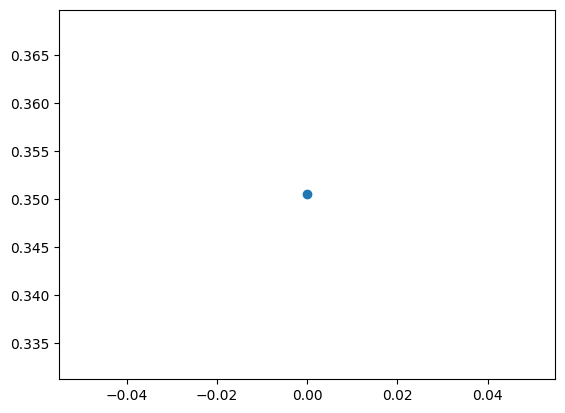

In [288]:
plt.plot(val_acc, 'o')

In [282]:
correct_pred

{'plane': 422,
 'car': 170,
 'bird': 436,
 'cat': 159,
 'deer': 248,
 'dog': 109,
 'frog': 272,
 'horse': 221,
 'ship': 492,
 'truck': 275}

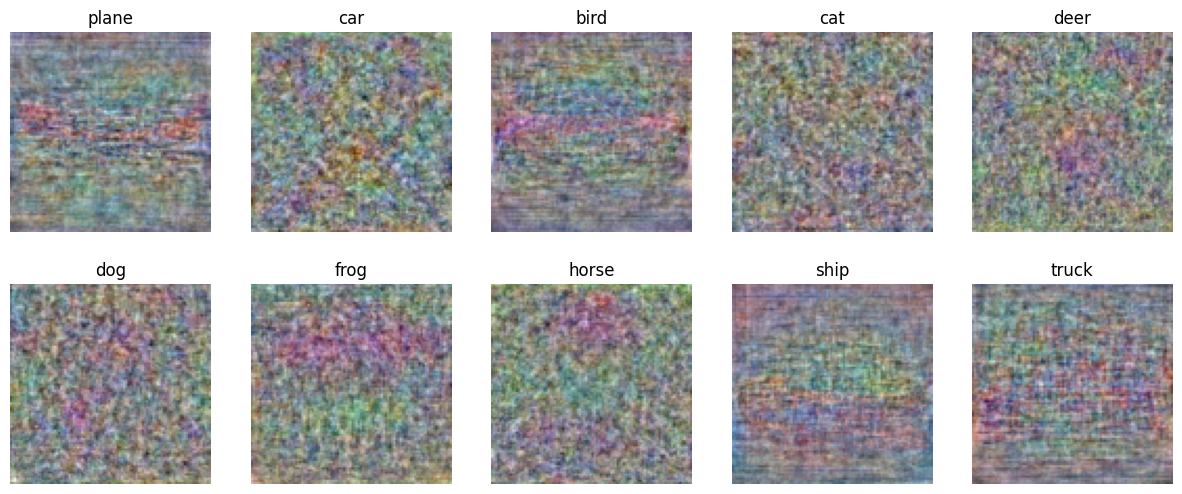

In [283]:
import matplotlib.pyplot as plt
import numpy as np

# Get the weights of the linear layer
weights = model.fc.weight.data

# Normalize the weights between 0 and 1
min_val = weights.min().item()
max_val = weights.max().item()
normalized_weights = (weights - min_val) / (max_val - min_val)

# Visualize the normalized weights as images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(normalized_weights[i].view(3, 96, 96).cpu().detach().numpy().transpose(1, 2, 0))
    ax.set_title(classes[i])
    ax.axis('off')

plt.show()
